# Object detection on MRI brain images

* Downloading dataset of three modalities (axial sagittal coronal)
* Copying all to folder data
* Split train data set into train and validation set

In [1]:
import kagglehub
import random, os
data_set_path = kagglehub.dataset_download("davidbroberts/brain-tumor-object-detection-datasets")

root='datasets'
!rm -rf {root}
!mkdir -p {root}/train/images
!mkdir -p {root}/train/labels
!mkdir -p {root}/val/images
!mkdir -p {root}/val/labels
!cp -n {data_set_path}/**/images/train/* {root}/train/images
!cp -n {data_set_path}/**/labels/train/* {root}/train/labels

traning_validation_split = .8
data_size = int(len(os.listdir(f'{root}/train/images')))
training_data_size = int(data_size * traning_validation_split)
validation_data_size = data_size - training_data_size

print(f'Training data size: {training_data_size}')
print(f'Validation data size: {validation_data_size}')

def move_data(source_dir, target_dir, n_files):
  all_images = os.listdir(f'{root}/train/images')
  random.shuffle(all_images)
  images_to_move = all_images[:validation_data_size]

  for image_name in images_to_move:
      label_name = image_name.replace('.jpg', '.txt')
      label_path = f'{source_dir}/labels/{label_name}'
      if os.path.exists(label_path):
          os.rename(f'{source_dir}/images/{image_name}', f'{target_dir}/images/{image_name}')
          os.rename(label_path, f'{target_dir}/labels/{label_name}')
      else:
          print(image_name + ' is missing label ' + label_path + ', ignoring.')

move_data(f'{root}/train', f'{root}/val', validation_data_size)

Training data size: 714
Validation data size: 179
00360_129.jpg is missing label datasets/train/labels/00360_129.txt, ignoring.
00364_107.jpg is missing label datasets/train/labels/00364_107.txt, ignoring.


Define dataset class to init and load data

In [2]:
!pip install pyyaml > /dev/null

import os
import yaml
import torch
from torch.utils.data import Dataset
from PIL import Image
from pathlib import Path

class BrainTumorDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.transform = transform

        image_paths = []
        label_paths = []

        self.populate(image_paths, images_dir)
        self.populate(label_paths, labels_dir)

        def basename(path):
            return os.path.splitext(os.path.basename(path))[0]

        image_basenames = {basename(path) for path in image_paths}
        label_basenames = {basename(path) for path in label_paths}
        matching_basenames = image_basenames & label_basenames

        self.image_paths = [path for path in image_paths if basename(path) in matching_basenames]
        self.label_paths = [path for path in label_paths if basename(path) in matching_basenames]

    def populate(self, file_paths, dir):
      for dir_path, dir_names, file_names in os.walk(dir):
          for file_name in file_names:
              file_path = os.path.join(dir_path, file_name)
              file_paths.append(file_path)
      file_paths.sort()

    def __len__(self):
        return len(self.image_paths)

    def extract_label(self, label_path, image_width, image_height):
        boxes = []
        labels = []
        with open(label_path, 'r') as file:
            for line in file.readlines():
                def scale(center, size, factor):
                    scaled_center = center * factor
                    scaled_size = size * factor
                    half_size = scaled_size / 2
                    return scaled_center - half_size, scaled_center + half_size

                columns = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, columns[:5])
                class_id = int(class_id)

                x_min, x_max = scale(x_center, width, image_width)
                y_min, y_max = scale(y_center, height, image_height)

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        return boxes, labels

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image_width, image_height = image.size

        label_path = self.label_paths[idx]
        boxes, labels = self.extract_label(label_path, image_width, image_height)

        if self.transform:
           image = self.transform(image)
           resize_scale = torch.tensor([image.shape[2] / image_height, image.shape[1] / image_width] * 2)
           boxes = boxes * resize_scale

        return {'image': image, 'boxes': boxes, 'labels': labels}

def collate_fn(batch):
    images = [item['image'] for item in batch]
    boxes = [item['boxes'] for item in batch]
    labels = [item['labels'] for item in batch]

    return {
        'images': torch.stack(images, dim=0),
        'boxes': boxes,
        'labels': labels
    }

Instantiate batch data loaders

In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms

target_image_size = 256
transform = transforms.Compose([
    transforms.Resize((target_image_size, target_image_size)),
    transforms.ToTensor(),
])

train_dataset = BrainTumorDataset(
    images_dir=root+'/train/images',
    labels_dir=root+'/train/labels',
    transform=transform
)

val_dataset = BrainTumorDataset(
  images_dir=root+'/val/images',
    labels_dir=root+'/val/labels',
    transform=transform
)

torch.manual_seed(0)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

Visualize sample data from training and validation set

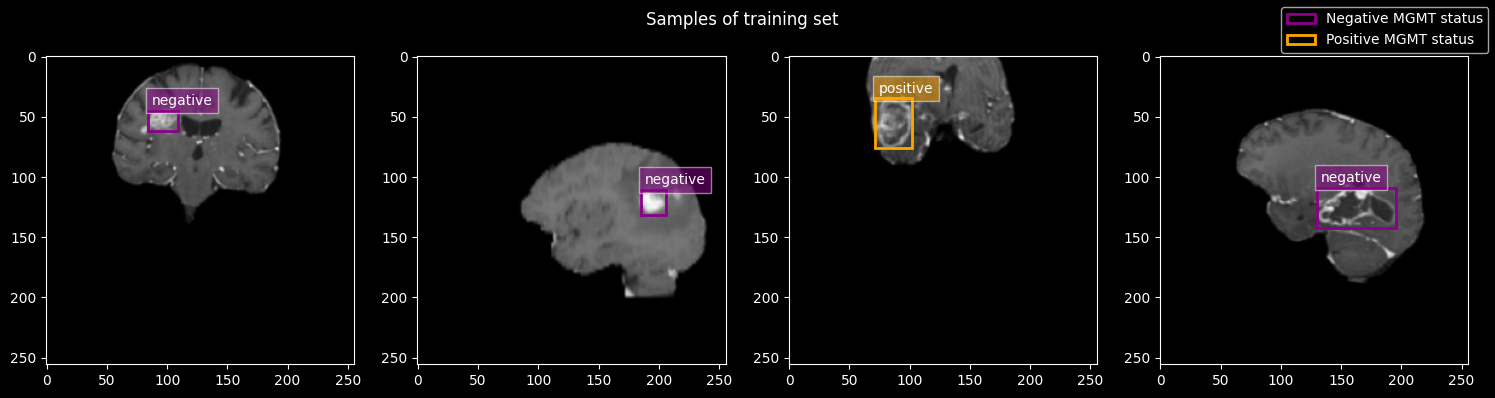

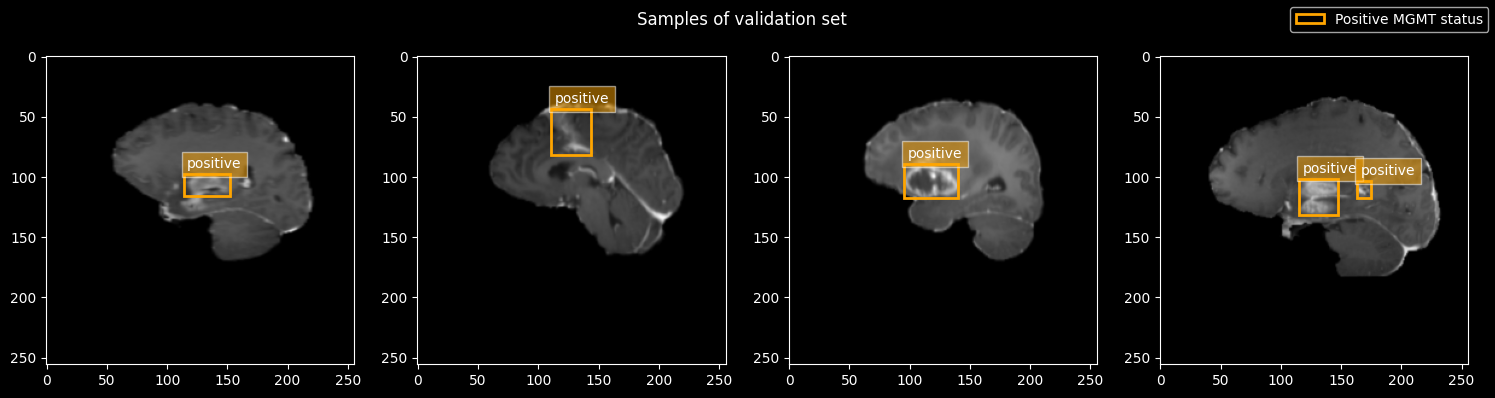

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

plt.style.use('dark_background')

class_colors = {
    0: 'darkmagenta',
    1: 'orange'
}

class_labels = {
    0: 'negative',
    1: 'positive'
}

def plot_instance(image, boxes, labels, confidences, ax):
    ax.imshow(image)
    for i, label in enumerate(labels):
        x_min, y_min, x_max, y_max = boxes[i]
        width, height = x_max - x_min,  y_max - y_min
        confidence = confidences[i]

        legend = ('Positive' if label.item() == 1 else 'Negative') + ' MGMT status'
        rect = plt.Rectangle((x_min, y_min),
                             width, height,
                             linewidth=2,
                             edgecolor=class_colors[label.item()],
                             facecolor='none',
                             label=legend)
        confidence_label = f' conf: {confidence:.2f}' if confidence < 1. else ''
        t = ax.text(x_min+3, y_min-5, class_labels[label.item()] + confidence_label)
        t.set_bbox(dict(facecolor=class_colors[label.item()], alpha=0.5))
        ax.add_patch(rect)

def add_legends(fig):
    box_legends = [ax.get_legend_handles_labels() for ax in fig.axes]
    box_legends, labels = [sum(lol, []) for lol in zip(*box_legends)]
    box_labeled_legends = OrderedDict(zip(labels, box_legends))
    fig.legend(box_labeled_legends.values(), box_labeled_legends.keys())

def visualize_data(data_loader, title):
    cols = 4
    rows = 1
    fig, axes = plt.subplots(rows, cols, figsize=(15 * rows, cols))
    axes = axes.flatten()
    batch = next(iter(data_loader))
    fig.suptitle(title)

    for i in range(cols * rows):
        image = batch['images'][i].permute(1, 2, 0).numpy()
        boxes = batch['boxes'][i]
        labels = batch['labels'][i]
        ground_truth_confidences = [1.]*len(labels)
        plot_instance(image, boxes, labels, ground_truth_confidences, axes[i])
        plt.tight_layout()

    add_legends(fig)
    plt.show()

visualize_data(train_loader, 'Samples of training set')
visualize_data(val_loader, 'Samples of validation set')

Download pretrained model

In [5]:
# Using Ultralytics pretrained model
# Jocher, G., Qiu, J., & Chaurasia, A. (2023). Ultralytics YOLO (Version 8.0.0) [Computer software]. https://github.com/ultralytics/ultralytics

!pip install ultralytics > /dev/null
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117 > /dev/null
from ultralytics import YOLO

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print('Using device:', device)

!rm runs -rf
model = YOLO('yolo11n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda


100%|██████████| 5.35M/5.35M [00:00<00:00, 61.0MB/s]


Configure data paths and train model on MRI data

In [6]:
import yaml

data = {
    'path': './',
    'train': 'train',
    'val': 'val',
    'nc': 2,
    'names': ['negative', 'positive']
}

with open(f'{root}/data.yaml', 'w') as f:
    yaml.dump(data, f)

model.train(data=root+'/data.yaml', 
            epochs=100, 
            imgsz=target_image_size, 
            batch=32,
            device=device, 
            patience=5,
            dropout=1e-2,
            lr0=5e-2,
            verbose=False,
           )

engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=datasets/data.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=256, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.01, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dyna

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]
2024-12-08 15:56:42,344	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-08 15:56:43,601	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/datasets/train/labels... 701 images, 15 backgrounds, 0 corrupt: 100%|██████████| 716/716 [00:00<00:00, 1175.63it/s]

train: New cache created: /kaggle/working/datasets/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/val/labels... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<00:00, 1173.28it/s]

val: New cache created: /kaggle/working/datasets/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       0.9G      1.768      3.591      1.202         27        256: 100%|██████████| 23/23 [00:03<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all        177        188     0.0025       0.69    0.00903    0.00475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.818G       1.42      1.927     0.9993         14        256: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

                   all        177        188    0.00323      0.903      0.169     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.826G      1.316      1.667      1.009         17        256: 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


                   all        177        188    0.00317      0.896      0.168      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.826G      1.348      1.561      1.018         19        256: 100%|██████████| 23/23 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all        177        188      0.589      0.184       0.46      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.826G      1.236      1.473     0.9979         18        256: 100%|██████████| 23/23 [00:02<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]


                   all        177        188      0.508      0.499      0.451      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.826G      1.285      1.436      1.015         17        256: 100%|██████████| 23/23 [00:02<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

                   all        177        188      0.432      0.536      0.378      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.826G      1.264      1.393     0.9975         16        256: 100%|██████████| 23/23 [00:02<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all        177        188      0.442      0.474      0.412      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.826G      1.249      1.358       1.01         16        256: 100%|██████████| 23/23 [00:02<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

                   all        177        188      0.439      0.784      0.493      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.826G      1.213      1.296      0.988         22        256: 100%|██████████| 23/23 [00:02<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all        177        188      0.476      0.835       0.51      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.828G      1.209      1.269      1.001         21        256: 100%|██████████| 23/23 [00:02<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

                   all        177        188      0.492      0.859      0.532      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.824G      1.184      1.252     0.9957         12        256: 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]

                   all        177        188      0.458      0.771      0.542      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.826G      1.178      1.231     0.9927         20        256: 100%|██████████| 23/23 [00:02<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]

                   all        177        188      0.469      0.825      0.564       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.824G      1.163      1.204     0.9891         15        256: 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all        177        188      0.481      0.812      0.548      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.828G      1.147      1.199     0.9757         21        256: 100%|██████████| 23/23 [00:02<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]

                   all        177        188      0.506      0.852        0.6      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.824G      1.114      1.158     0.9728         19        256: 100%|██████████| 23/23 [00:02<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all        177        188      0.525      0.877      0.576       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.824G      1.144      1.156     0.9727         20        256: 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

                   all        177        188      0.503      0.803      0.552      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.824G      1.079       1.11     0.9639         14        256: 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all        177        188      0.525      0.783      0.599      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.826G      1.158      1.161     0.9865         23        256: 100%|██████████| 23/23 [00:02<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all        177        188      0.493      0.754      0.624      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.824G      1.112      1.128      0.972         16        256: 100%|██████████| 23/23 [00:02<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]

                   all        177        188      0.507      0.834      0.626      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.826G      1.117      1.127     0.9676         17        256: 100%|██████████| 23/23 [00:02<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

                   all        177        188      0.525      0.767      0.667       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.824G      1.091      1.066     0.9534         19        256: 100%|██████████| 23/23 [00:02<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all        177        188      0.441      0.814      0.615      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.824G      1.104      1.087     0.9654         21        256: 100%|██████████| 23/23 [00:02<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

                   all        177        188      0.532      0.696      0.572      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.824G      1.138       1.11      0.983         10        256: 100%|██████████| 23/23 [00:02<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]

                   all        177        188      0.586      0.752      0.685      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.824G      1.074      1.059     0.9592         20        256: 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all        177        188      0.595      0.773      0.689      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.824G      1.119      1.094     0.9727         18        256: 100%|██████████| 23/23 [00:02<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

                   all        177        188       0.49      0.691      0.557      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.824G      1.084      1.083     0.9527         17        256: 100%|██████████| 23/23 [00:02<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

                   all        177        188      0.512      0.796      0.662      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.824G      1.056      1.023     0.9516         19        256: 100%|██████████| 23/23 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

                   all        177        188      0.664      0.694      0.694      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.826G      1.038     0.9985     0.9396         17        256: 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

                   all        177        188      0.568      0.777      0.707      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.824G      1.063      1.002     0.9428         19        256: 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

                   all        177        188      0.581      0.749      0.693      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.826G      1.061      1.026     0.9419         21        256: 100%|██████████| 23/23 [00:02<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

                   all        177        188      0.561      0.823      0.733      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.824G      1.063      1.008     0.9404         25        256: 100%|██████████| 23/23 [00:02<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

                   all        177        188      0.614      0.781      0.715      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.824G      1.067          1      0.953         19        256: 100%|██████████| 23/23 [00:02<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

                   all        177        188      0.631        0.7      0.742      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.824G      1.051      1.002     0.9425         22        256: 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.28it/s]

                   all        177        188      0.607      0.759      0.694      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.824G       1.03     0.9891     0.9551         20        256: 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all        177        188       0.72      0.727      0.753      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.824G      1.032     0.9398     0.9391         21        256: 100%|██████████| 23/23 [00:02<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

                   all        177        188      0.642      0.726      0.725       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.824G      1.032     0.9405     0.9415         23        256: 100%|██████████| 23/23 [00:02<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]

                   all        177        188      0.647      0.725       0.74      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.824G      1.036     0.9708     0.9369         18        256: 100%|██████████| 23/23 [00:02<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]

                   all        177        188      0.569       0.66       0.66      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.824G      1.033     0.9915     0.9658         13        256: 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

                   all        177        188      0.706      0.728      0.783      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.824G      1.012     0.9836     0.9324         25        256: 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

                   all        177        188      0.662      0.758      0.752      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.824G      1.035     0.9488     0.9364         18        256: 100%|██████████| 23/23 [00:02<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all        177        188      0.535      0.804        0.7       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.824G      1.042     0.9651     0.9306         18        256: 100%|██████████| 23/23 [00:02<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

                   all        177        188      0.629      0.765       0.75      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.824G      1.043     0.9146     0.9329         23        256: 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

                   all        177        188      0.626       0.79      0.748      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.824G     0.9808     0.9096     0.9335         16        256: 100%|██████████| 23/23 [00:02<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all        177        188      0.625      0.828      0.747      0.524


EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 38, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

43 epochs completed in 0.049 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.47 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


                   all        177        188      0.707      0.728      0.783      0.551
Speed: 0.0ms preprocess, 0.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79aea0332860>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

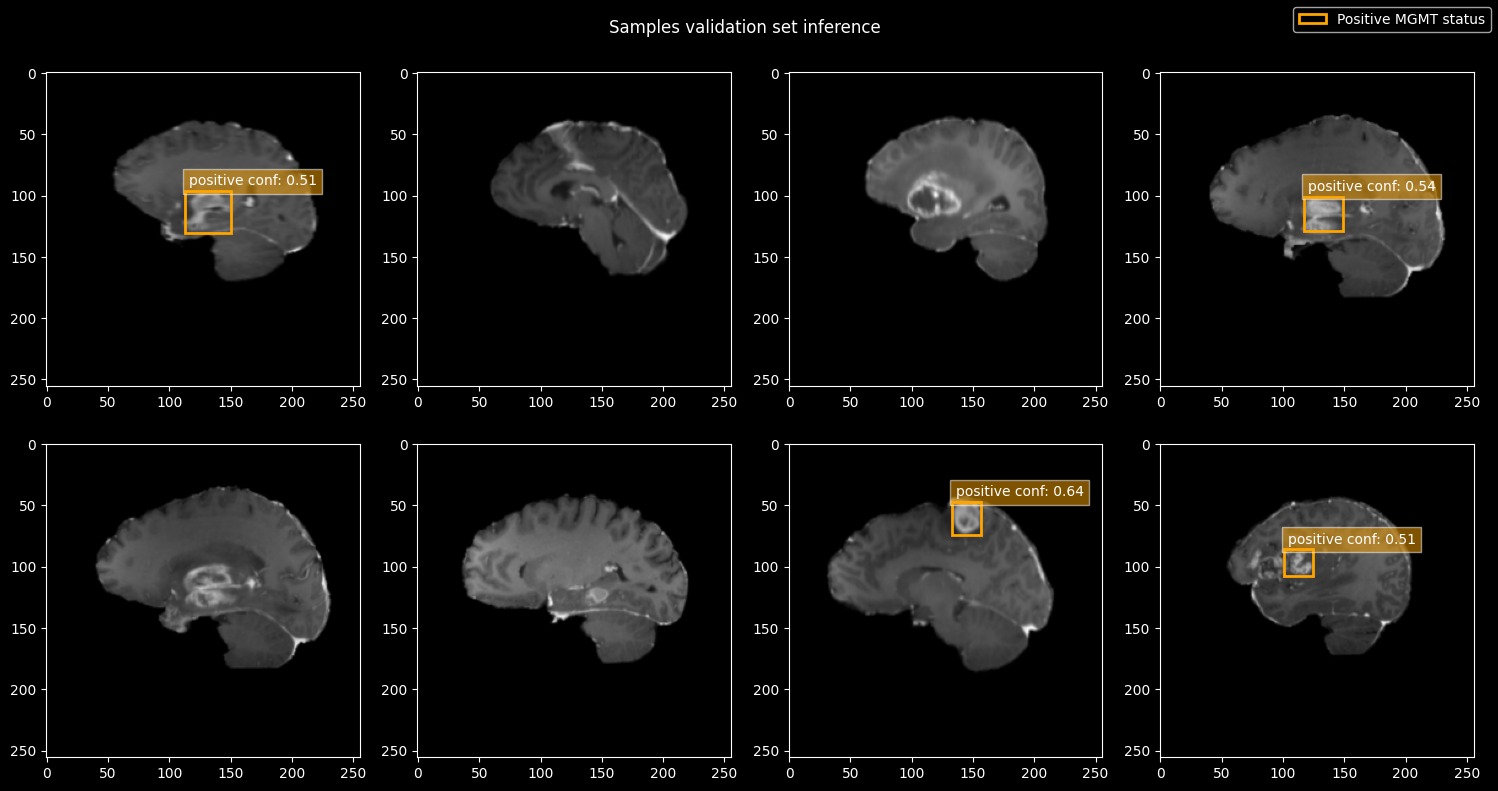

In [7]:
confidence_threshold = .45

def visualize_inference(model, data_loader, title):
      rows = 2
      cols = 4
      fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
      axes = axes.flatten()
      plt.suptitle(title)
      batch = next(iter(data_loader))
      batch = next(iter(data_loader))
      results = model.predict(batch['images'].half().to(device), verbose=False)
      for i, result in enumerate(results):
          if i > rows * cols - 1:
              break
          boxes = result.boxes.xyxy  # Bounding box coordinates (x1, y1, x2, y2)
          scores = result.boxes.conf  # Confidence scores
          classes = result.boxes.cls  # Predicted classes

          confident_prediction_indices = scores > confidence_threshold
          boxes = boxes[confident_prediction_indices].cpu()
          scores = scores[confident_prediction_indices].cpu()
          classes = classes[confident_prediction_indices].cpu()

          image = batch['images'][i].permute(1, 2, 0).cpu().numpy()
          plot_instance(image, boxes, classes, scores, axes[i])
          plt.tight_layout()
      add_legends(fig)
      plt.show()

best_models = !find runs -name best.pt | sort
model = YOLO(best_models[-1])
model.eval()
visualize_inference(model, val_loader, 'Samples validation set inference')

In [8]:
import numpy as np
from torchvision.ops import box_iou
num_classes = len(class_labels)

# Function to calculate Precision and Recall for each image
def calculate_precision_recall(pred_boxes, pred_labels, true_boxes, true_labels, iou_threshold):
    # Convert boxes to PyTorch tensors if they are not already

    pred_boxes = torch.tensor(pred_boxes).clone().detach().to(device)
    true_boxes = torch.tensor(true_boxes).clone().detach().to(device)

    # Calculate IoU between predicted and true boxes
    iou = box_iou(pred_boxes, true_boxes)
    tp = 0  # True Positives
    fp = 0  # False Positives
    confusion_matrix = np.zeros((2, 2), dtype=int)

    # Create a copy of true boxes and labels for removing matched ones
    remaining_true_boxes = true_boxes.clone()
    remaining_true_labels = true_labels.clone()


    for pred_idx, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):
        # Find best matching ground truth box for this prediction
        best_iou = 0
        best_gt_idx = -1

        for gt_idx, (true_box, true_label) in enumerate(zip(remaining_true_boxes, remaining_true_labels)):
            current_iou = iou[pred_idx, gt_idx].item()
            if current_iou > best_iou and pred_label == true_label:  # Check label match
                best_iou = current_iou
                best_gt_idx = gt_idx

        # Classify prediction as TP or FP
        if best_iou >= iou_threshold and best_gt_idx != -1:  # Check for valid match
            tp += 1
            orig_idx = (true_boxes == true_boxes[best_gt_idx]).all(dim=1).nonzero(as_tuple=True)[0].item()
            confusion_matrix[int(pred_label.item()), true_labels[orig_idx].item()] += 1

            # Remove matched box from remaining boxes and labels
            remaining_true_boxes = remaining_true_boxes[torch.arange(remaining_true_boxes.shape[0]) != best_gt_idx]
            remaining_true_labels = remaining_true_labels[torch.arange(remaining_true_labels.shape[0]) != best_gt_idx]

        else:
            fp += 1
            confusion_matrix[int(pred_label.item()), -1] += 1
            # Handle case when best_gt_idx is -1: either no overlap or different label

    # Calculate False Negatives (unmatched ground truth boxes)
    fn = len(remaining_true_boxes)

    # Calculate precision and recall
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    return precision, recall, confusion_matrix

def evaluate(iou_threshold):
    with torch.no_grad():
        total_precision = 0.0
        total_recall = 0.0
        num_samples = 0
        confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
        for batch in val_loader:
            predictions = model.predict(batch['images'].half().to(device), verbose=False);
            for i, prediction in enumerate(predictions):
                predicted_boxes = prediction.boxes.xyxy
                predicted_scores = prediction.boxes.conf
                predicted_classes = prediction.boxes.cls

                confident_prediction_indices = predicted_scores > iou_threshold
                predicted_boxes = predicted_boxes[confident_prediction_indices]
                predicted_scores = predicted_scores[confident_prediction_indices]
                predicted_classes = predicted_classes[confident_prediction_indices]

                images = batch['images'][i].permute(1, 2, 0).numpy()
                ground_truth_boxes = batch['boxes'][i]
                ground_truth_labeles = batch['labels'][i]

                precision, recall, batch_confusion_matrix = calculate_precision_recall(predicted_boxes, predicted_classes, ground_truth_boxes, ground_truth_labeles, iou_threshold)
                confusion_matrix += batch_confusion_matrix
                total_precision += precision
                total_recall += recall
                num_samples += 1

        mean_precision = total_precision / num_samples if num_samples > 0 else 0
        mean_recall = total_recall / num_samples if num_samples > 0 else 0

        return mean_precision, mean_recall, confusion_matrix

mean_precision, mean_recall, confusion_matrix = evaluate(iou_threshold=.5);

/tmp/ipykernel_23/260226656.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_boxes = torch.tensor(pred_boxes).clone().detach().to(device)
/tmp/ipykernel_23/260226656.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_boxes = torch.tensor(true_boxes).clone().detach().to(device)


Mean Precision: 0.3955, Mean Recall: 0.3927


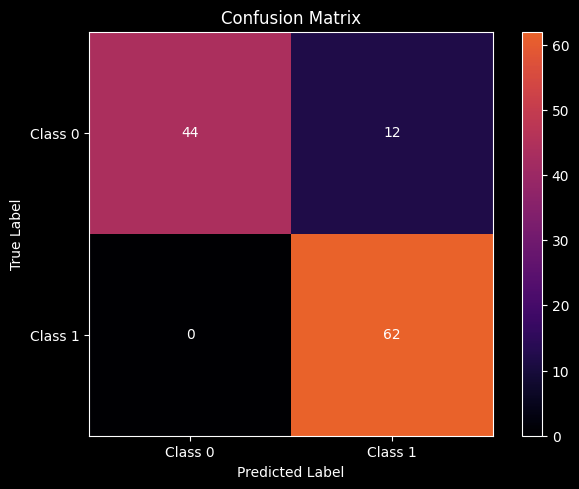

In [9]:
from matplotlib.colors import LinearSegmentedColormap

def plot_confusion_matrix(confusion_matrix):
    cmap = plt.get_cmap('inferno')
    colors = cmap(np.linspace(0., .65, cmap.N // 2))
    heatmap = LinearSegmentedColormap.from_list('Upper Half', colors)
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=heatmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Add labels to axes
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, [f'Class {i}' for i in range(num_classes)])
    plt.yticks(tick_marks, [f'Class {i}' for i in range(num_classes)])

    # Add text annotations
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, confusion_matrix[i, j], color='white',
                     ha='center', va='center')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print(f"Mean Precision: {mean_precision:.4f}, Mean Recall: {mean_recall:.4f}")
plot_confusion_matrix(confusion_matrix)